In [1]:
# libraries required for data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libraries required for data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# libraries required for ML
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

Reference

[Time Series Anomaly Detection](https://arxiv.org/pdf/1708.03665.pdf)

[Time Series LSTM](https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=KTqY8r6_Zpev) from [this](https://www.youtube.com/watch?v=c0k-YLQGKjY) youtube video

# Data Import

In [2]:
column_mapping = {
    'relative_humidity': 'humidity',
    'pir_sensor': 'pir',
    'light_switch': 'light'
}

# read in csv files
# df_original = pd.read_csv("smart_home_dataset.csv").rename(columns=column_mapping)
df_original = pd.read_csv("smart_home_dataset.csv").rename(columns=column_mapping)[-43200:]

# no movement
anomaly1 = pd.read_csv("anomaly_1.csv").rename(columns=column_mapping)
# 3h no movement
anomaly2 = pd.read_csv("anomaly_2.csv").rename(columns=column_mapping)
# midnight move
anomaly3 = pd.read_csv("anomaly_3.csv").rename(columns=column_mapping)

In [3]:
df_original.describe()

,temperature,humidity,light,ultrasonic,pir,pressure
count,43200.000000,43200.000000,43200.000000,43200.000000,43200.00000,43200.000000
mean,28.618056,75.465278,0.206505,0.020833,0.05706,0.379074
std,2.022798,11.315996,0.404802,0.142828,0.23196,0.485162
min,24.000000,49.000000,0.000000,0.000000,0.00000,0.000000
25%,27.000000,66.000000,0.000000,0.000000,0.00000,0.000000
50%,28.000000,74.000000,0.000000,0.000000,0.00000,0.000000
75%,30.000000,84.000000,0.000000,0.000000,0.00000,1.000000
max,33.000000,100.000000,1.000000,1.000000,1.00000,1.000000


# Data Visualization

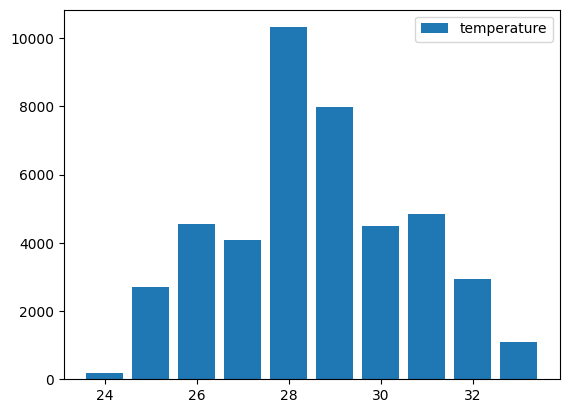

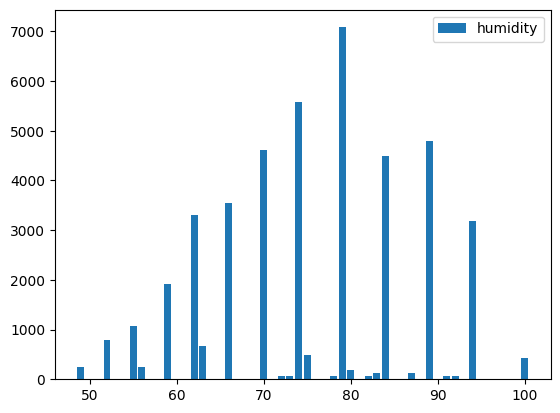

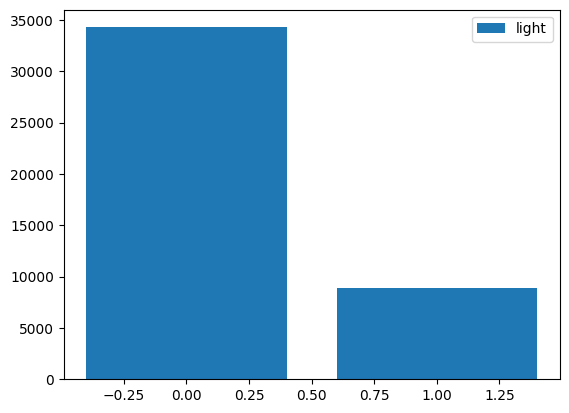

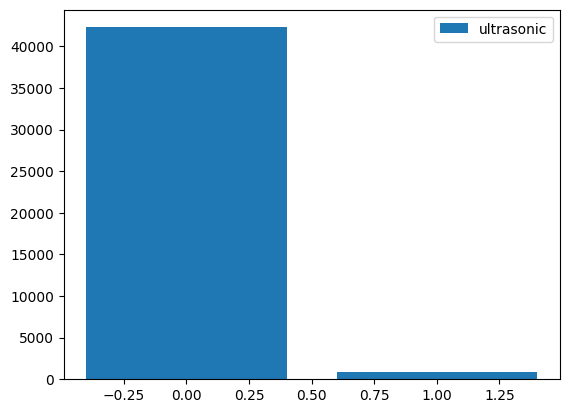

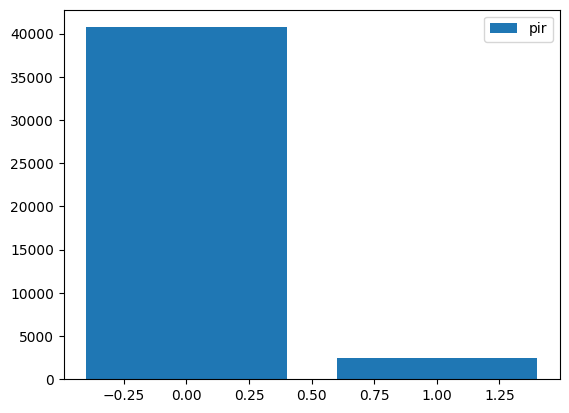

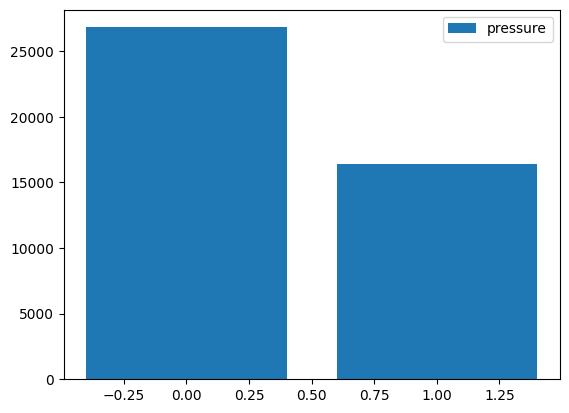

{'light': 3.842506445465755, 'ultrasonic': 47.0, 'pir': 16.525354969574035, 'pressure': 1.6380068392769906}


In [7]:
curr_df = df_original.copy()
processed_curr_df = df_time_preprocess(curr_df.copy())

# FEATURE_COLS = ['temperature', 'humidity']
FEATURE_COLS = ['pir', 'light', 'ultrasonic', 'pressure', 'temperature', 'humidity']
FEATURE_COUNT = len(FEATURE_COLS)
WINDOW_SIZE = 60

multiplier = {}

for col in curr_df.columns:
    if col in FEATURE_COLS:
        col_freq = curr_df[col].value_counts()
        if len(col_freq) == 2:
            ratio = max(col_freq[0], col_freq[1]) / min(col_freq[0], col_freq[1])
            multiplier[col] = ratio
        plt.bar(col_freq.index, col_freq.values, label=col)
        plt.legend()
        plt.show()
        
        
print(multiplier)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

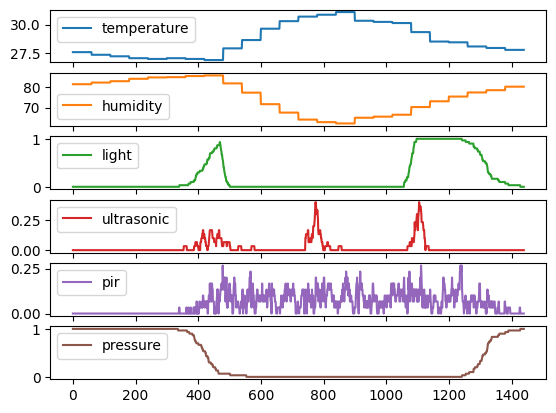

In [8]:
# 1: no movement, 2: 3h no movement, 3: midnight move
curr_df = df_original.copy()
curr_df = curr_df.drop(columns=['date_time']).groupby('time').mean().reset_index()

curr_df[[col for col in curr_df.columns if col not in ['hour_of_day', 'day_of_week']]].plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

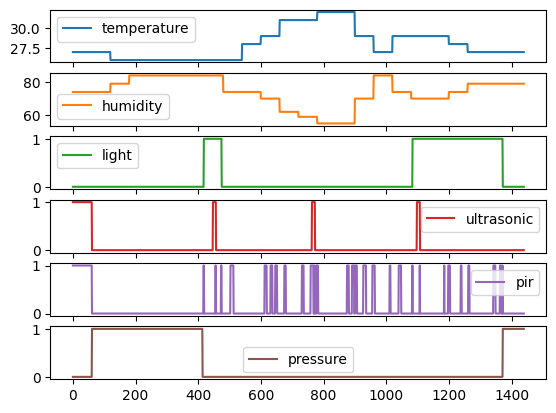

In [9]:
# 1: no movement, 2: 3h no movement, 3: midnight move
curr_df = anomaly3.copy()
curr_df = curr_df.drop(columns=['date_time']).groupby('time').mean().reset_index()

curr_df[[col for col in curr_df.columns if col not in ['hour_of_day', 'day_of_week']]].plot(subplots=True)

# Data Pre-processing Utility Functions

In [6]:
# pre-processing utility functions
def df_time_preprocess(df):
    # Create a temporary DataFrame to avoid modifying the input df
    temp_df = df.copy()

    # Convert to date_time object
    temp_df["date_time"] = pd.to_datetime(temp_df["date_time"])

    # Day of Week Column
    temp_df["date"] = temp_df["date_time"].dt.strftime("%Y-%m-%d")

    # Time of Day Column
    temp_df["hour_of_day"] = temp_df["date_time"].dt.strftime("%H")
    temp_df['minute_of_day'] = temp_df['date_time'].dt.strftime('%M')
    
    # Columns Cleanup
    temp_df["hour_of_day"] = pd.to_numeric(temp_df["hour_of_day"])
    temp_df["minute_of_day"] = pd.to_numeric(temp_df["minute_of_day"])
#     temp_df["day_of_week"] = pd.to_numeric(temp_df["day_of_week"])

    temp_df['minute_of_day'] = temp_df['hour_of_day'] * 60 + temp_df['minute_of_day']
    temp_df = temp_df.drop(columns=["date_time", "date", 'time'])
    
    temp_df['hour_of_day'] = temp_df['hour_of_day'] / 24.0
    temp_df['minute_of_day'] = temp_df['minute_of_day'] / 1440.0

    return temp_df

def window_slicing(df, feature_count, window_size = 60):
    df = df.to_numpy()
    X, y = [], []
    
    for i in range(len(df) - window_size):
        row = [r for r in df[i : i+window_size]]
        X.append(row)
        label = [df[i + window_size][j] for j in range(feature_count)]
        y.append(label)  
    
    return np.array(X), np.array(y)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
def data_preprocess(df, target_col):
    df[target_col] = scaler.fit_transform(df[[target_col]])
    return df

# Original Data

In [29]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

curr_df = df_original.copy()
curr_df = df_time_preprocess(curr_df)

non_feature_cols = [col for col in curr_df.columns if col not in FEATURE_COLS]
curr_df = curr_df[FEATURE_COLS + non_feature_cols]

train_data = curr_df.copy()

trained_models = []

for feature in FEATURE_COLS:
    temp = train_data.loc[:, [feature, 'hour_of_day', 'minute_of_day']]
    model = xgb.XGBRegressor()
    model.fit(temp[['hour_of_day', 'minute_of_day']], temp[feature])

    trained_models.append(model)

Mean Squared Error: 0.0


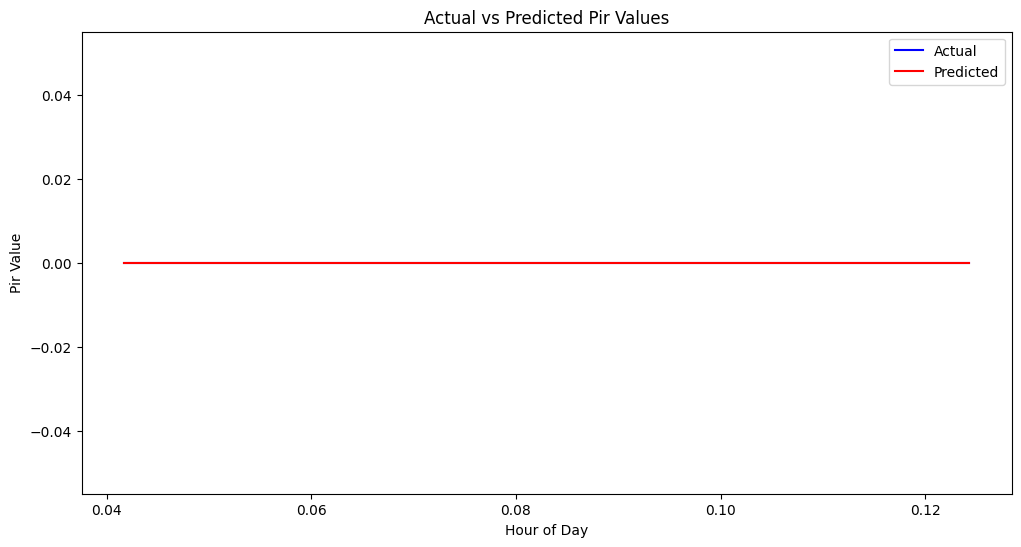

Mean Squared Error: 0.0


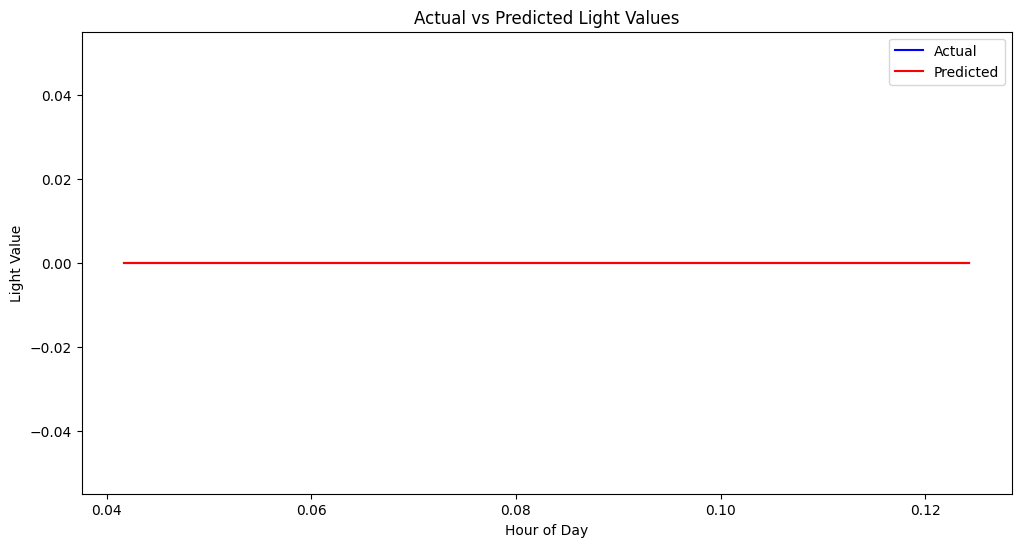

Mean Squared Error: 0.0


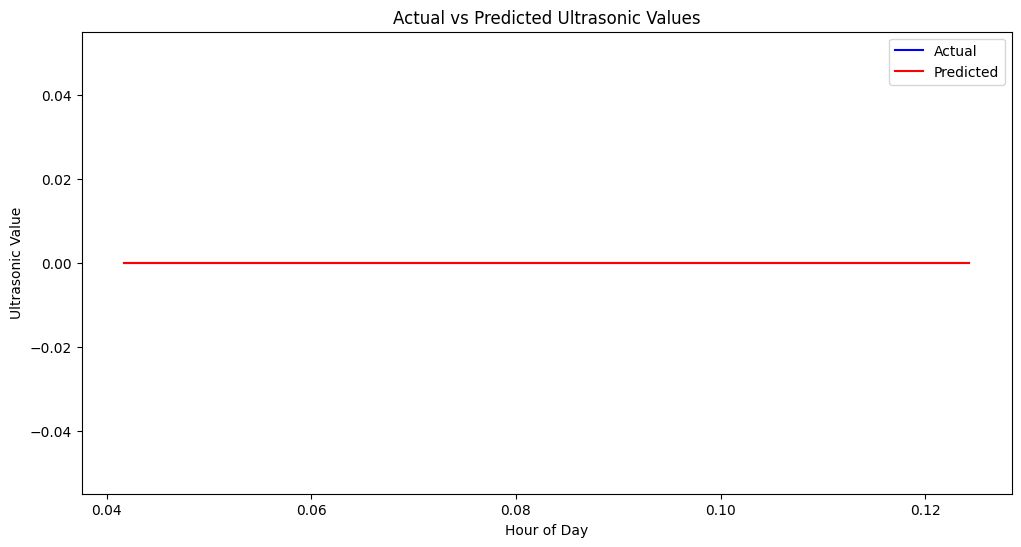

Mean Squared Error: 0.0


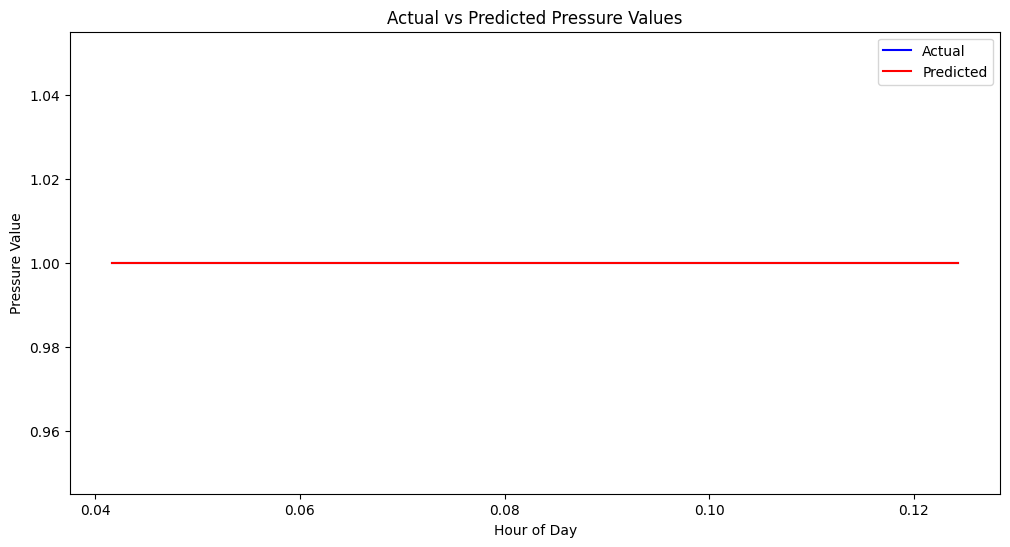

Mean Squared Error: 160.88952297741344


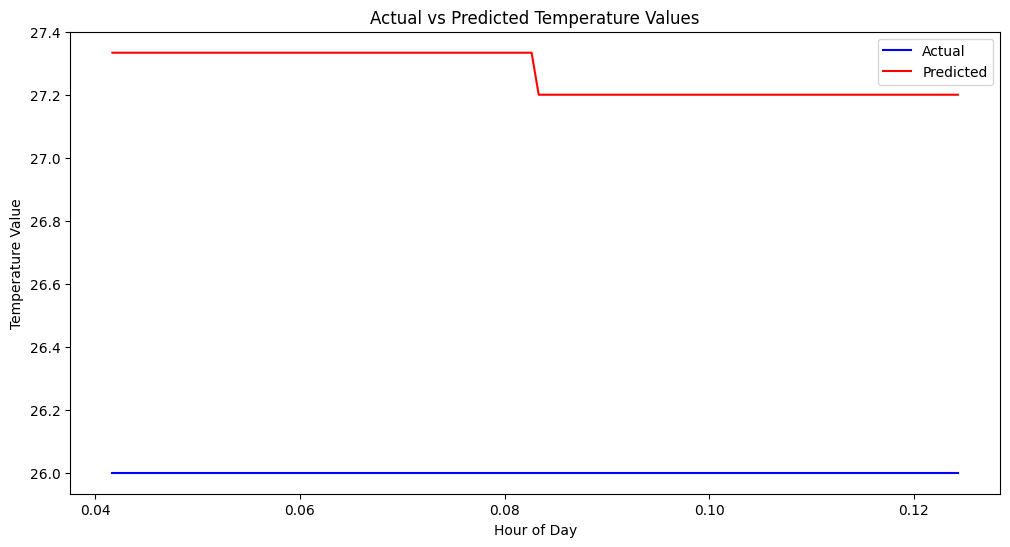

Mean Squared Error: 576.2227444211021


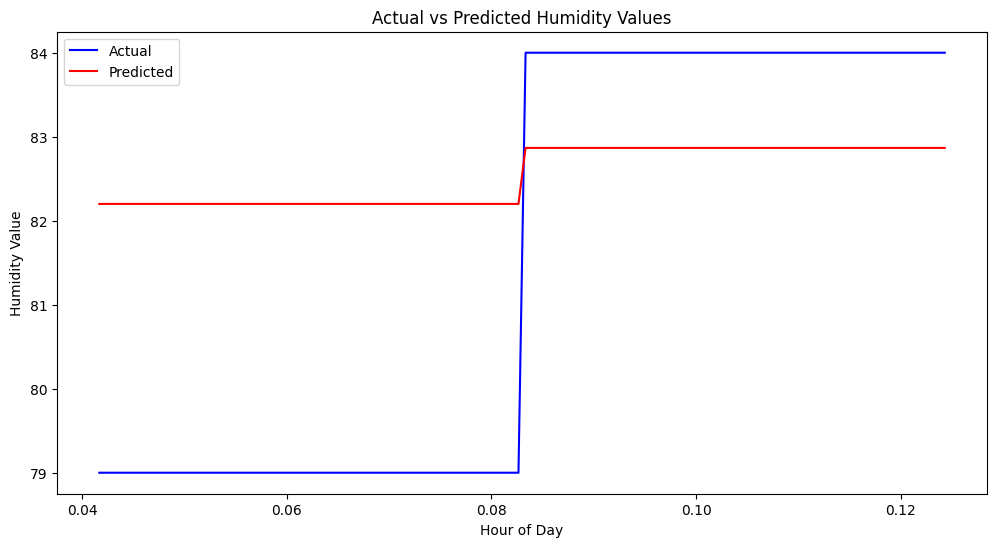

In [40]:
# 1: no movement, 2: 3h no movement, 3: midnight move
curr_df = anomaly1.copy()

# exploration by hour
start_hour = 1
end_hour = start_hour + 1
start_index, end_index = (start_hour*60), int((end_hour+1)*60)
curr_df = df_time_preprocess(curr_df[start_index:end_index])

# # exploration by day
# day = 10
# curr_df = df_time_preprocess(curr_df)[day * 1440:(day+1) * 1440]

# # exploration by whole df
# curr_df = df_time_preprocess(curr_df)

# rearranging columns
non_feature_cols = [col for col in curr_df.columns if col not in FEATURE_COLS]
curr_df = curr_df[FEATURE_COLS + non_feature_cols]

# defining some threshold for cleaner prediction data
feature_thresholds = {
    'pir': {'lower': 0.4, 'upper': 0.8},
    'light': {'lower': 0.3, 'upper': 0.6},
    'ultrasonic': {'lower': 0.2, 'upper': 0.4},
    'pressure': {'lower': 0.3, 'upper': 0.7},
    'temperature': {'lower': 0.2, 'upper': 0.8},
    'humidity': {'lower': 0.2, 'upper': 0.8},
}
        
test_data = curr_df.copy()
for idx, trained_model in enumerate(trained_models):
    
    target_feature = FEATURE_COLS[idx]
    feature_test_data = test_data.loc[:, target_feature]
    
    predictions = trained_model.predict(test_data[['hour_of_day', 'minute_of_day']])
    if target_feature not in ['temperature', 'humidity']:
        upper_threshold = feature_thresholds[target_feature]['upper']
        lower_threshold = feature_thresholds[target_feature]['lower']

        predictions = np.where(predictions > upper_threshold, 1, predictions)
        predictions = np.where(predictions < lower_threshold, 0, predictions)
    
    predictions = predictions.reshape(-1, 1)
    
    mse = mean_squared_error(feature_test_data, predictions)
    mae = mean_absolute_percentage_error(feature_test_data, predictions)
    
    print(f'Mean Squared Error: {mse*100}')

    plt.figure(figsize=(12, 6))
    plt.plot(test_data['minute_of_day'], feature_test_data, label='Actual', color='blue')
    plt.plot(test_data['minute_of_day'], predictions, label='Predicted', color='red')
    plt.title(f'Actual vs Predicted {target_feature.capitalize()} Values')
    plt.xlabel('Hour of Day')
    plt.ylabel(f'{target_feature.capitalize()} Value')
    plt.legend()
    plt.show()